In [216]:
import os
import time
import folium
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from turtle import color
from folium import plugins
import matplotlib.pyplot as plt
%matplotlib inline
from folium.plugins import FastMarkerCluster
pd.options.mode.chained_assignment = None  #close copy warning   

In [217]:
property_df = pd.read_csv("../data/curated/property_GNR.csv")

In [218]:
property_df.head(2)

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,TRAM STATION,BUS,Education,Commercial,Environment,Medication,Secrity,Industrial,Prison,Transportation
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,14,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,127.0,54.0,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0
1,11a/131 Lonsdale Sreet Melbourne VIC 3000,350,11,MELBOURNE,3000,Studio,1,0,0,1,...,127.0,54.0,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0


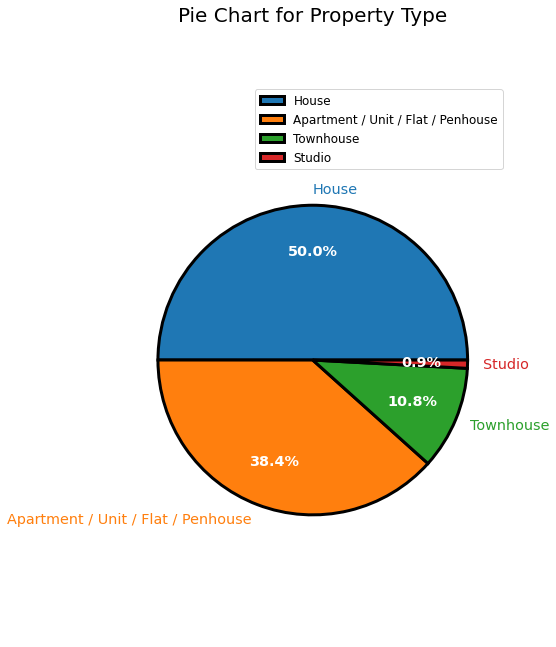

In [219]:
pie_data = property_df['type'].value_counts()
labels = pie_data.index
sizes = pie_data.values
#get label and size
fig, ax = plt.subplots(figsize = (10,9))
#draw the pie char and modify the pie chart
patches, texts, pcts = ax.pie(pie_data ,explode=None,autopct='%1.1f%%',
                               pctdistance = 0.7, labels=labels,wedgeprops={'linewidth': 3.0, 'edgecolor': 'black'},
                               textprops={'size': 'x-large'})

plt.setp(pcts, color='white', fontweight='bold')  #label color
# face color.
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.legend(labels,prop={'size': 12},bbox_to_anchor=(1.0, 1.0))
plt.title("Pie Chart for Property Type", x=0.5, y=1.1,fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

fig.figure.savefig('../plots/type_pie.png')

In [220]:
property_df['counts'] = 1

In [221]:
count_number = property_df.groupby('suburb').agg('count')[['counts']].reset_index()
count_number

,suburb,counts
0,ABBOTSFORD,40
1,ABERFELDIE,11
2,ADAMS ESTATE,6
3,ADDINGTON,4
4,ADELAIDE LEAD,1
...,...,...
565,YARRAGON,1
566,YARRAM,1
567,YARRAVILLE,65
568,YARRAWONGA,16


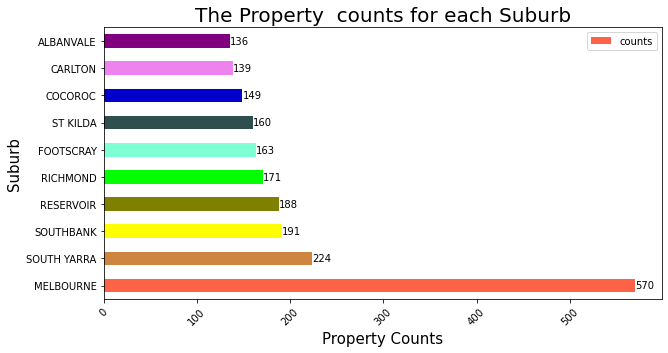

In [222]:
data = count_number.sort_values(by=['counts'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="counts",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine',
                            'darkslategray', 'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Property Counts", fontsize=15)
plt.title("The Property  counts for each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/property_count.png')

In [223]:
mean_suburb = property_df.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
mean_suburb

,suburb,rent_weekly
0,ABBOTSFORD,571.875000
1,ABERFELDIE,490.454545
2,ADAMS ESTATE,470.833333
3,ADDINGTON,388.750000
4,ADELAIDE LEAD,380.000000
...,...,...
565,YARRAGON,420.000000
566,YARRAM,585.000000
567,YARRAVILLE,437.907692
568,YARRAWONGA,386.562500


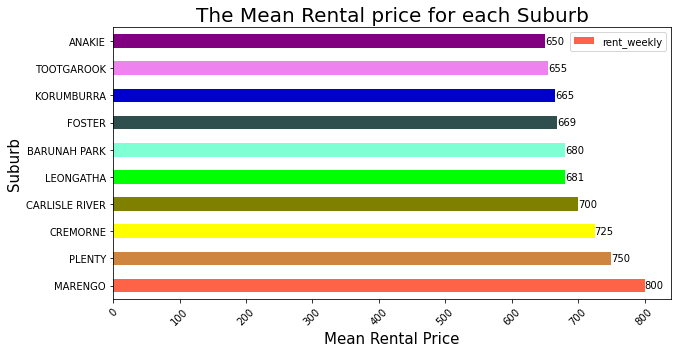

In [224]:
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price", fontsize=15)
plt.title("The Mean Rental price for each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/suburb_mean_desc.png')

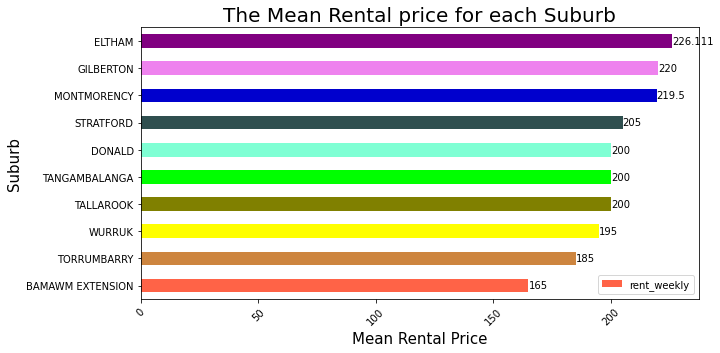

In [225]:
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=True).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price", fontsize=15)
plt.title("The Mean Rental price for each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/suburb_mean_asce.png')

In [226]:
property_df['type']= property_df['type'].replace('Townhouse','House')

In [227]:
apa = property_df[property_df['type'] == 'Apartment / Unit / Flat / Penhouse']
house = property_df[property_df['type'] == 'House']

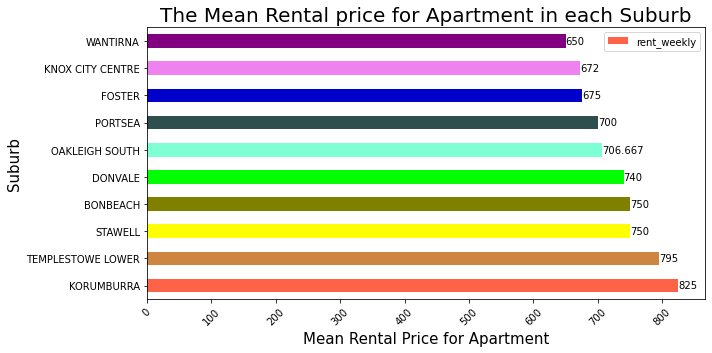

In [228]:
mean_suburb = apa.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for Apartment", fontsize=15)
plt.title("The Mean Rental price for Apartment in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/apa_suburb_mean_desc.png')

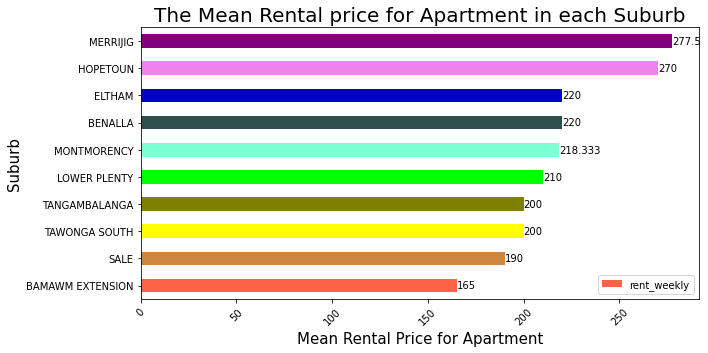

In [229]:
mean_suburb = apa.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=True).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for Apartment", fontsize=15)
plt.title("The Mean Rental price for Apartment in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/apa_suburb_mean_asce.png')

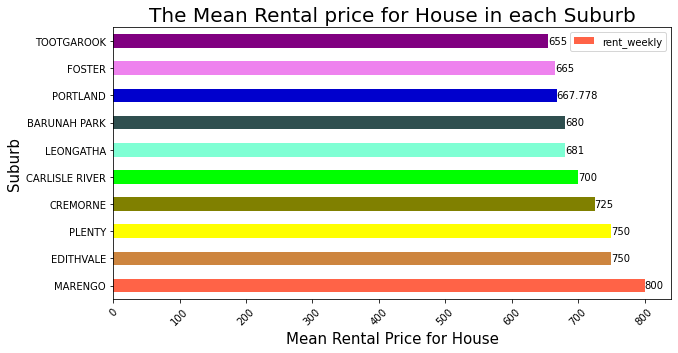

In [230]:
mean_suburb = house.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for House", fontsize=15)
plt.title("The Mean Rental price for House in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/house_suburb_mean_desc.png')

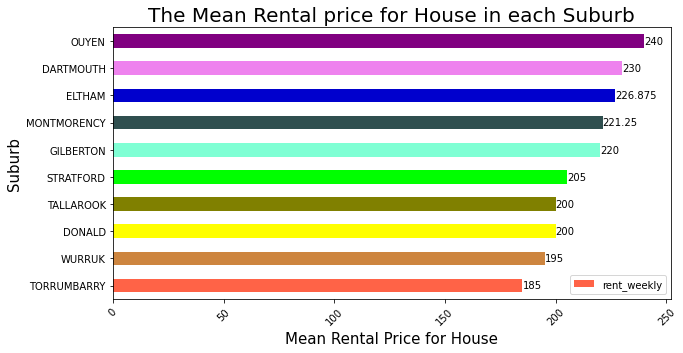

In [231]:
mean_suburb = house.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=True).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine', 'darkslategray',
                            'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for House", fontsize=15)
plt.title("The Mean Rental price for House in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/house_suburb_mean_asce.png')

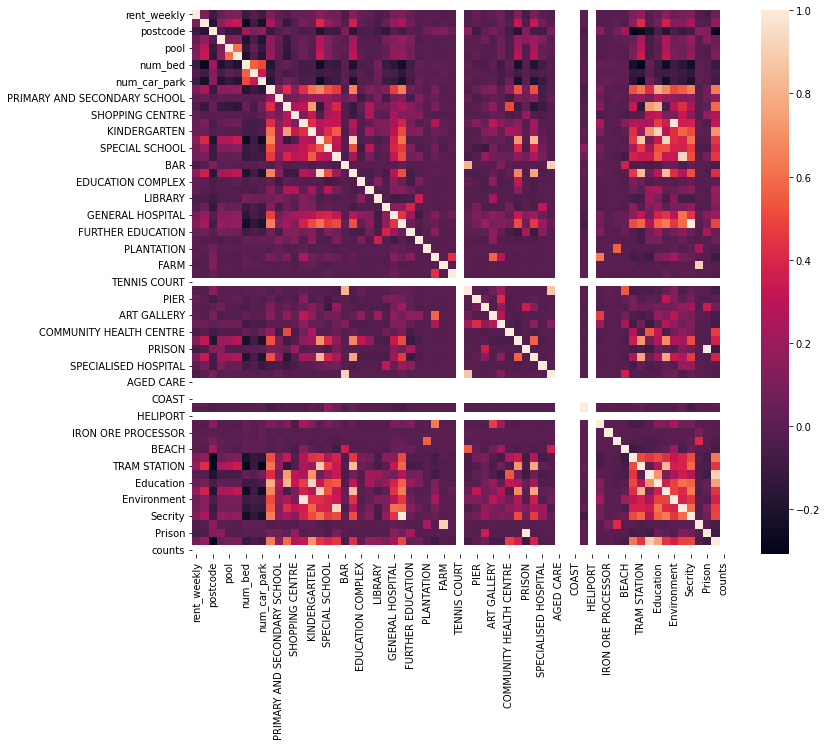

In [232]:
# Pearson correlation
fig, ax = plt.subplots(figsize = (12,10))
fig = sns.heatmap(property_df.corr())
fig.figure.savefig('../plots/heatmap.png',bbox_inches = 'tight')

In [233]:
property_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(30)

,rent_weekly
rent_weekly,1.000000
TRAM STATION,0.174567
Commercial,0.156781
POST OFFICE,0.147616
SPORTS COMPLEX,0.133844
MARKET,0.123225
Secrity,0.117222
POLICE STATION,0.117222
TRAIN STATION,0.113993
gym,0.109401


In [259]:
property_df['livable'] = property_df['Commercial']*0.4 + property_df['BUS']*0.05 + property_df['TRAIN STATION']*0.1+ property_df['TRAM STATION']*0.1+ property_df['Secrity']*0.1 + property_df['Medication']*0.1 + property_df['Environment']*0.1 + property_df['Education']*0.2 - property_df['Prison']*0.3 - property_df['Industrial']*0.1
property_df = property_df.sort_values(by=['livable'], ascending=False)
property_df.head(10)

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,Education,Commercial,Environment,Medication,Secrity,Industrial,Prison,Transportation,counts,livable
226,5008/500 Elizabeth Street Melbourne VIC 3000,550,50,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,1,28.1
85,718/112 Abeckett Street Melbourne VIC 3000,650,7,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,1,28.1
49,5104/462 Elizabeth Street Melbourne VIC 3000,450,51,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,1,28.1
211,2209/181 ABeckett Street Melbourne VIC 3000,650,22,MELBOURNE,3000,Studio,1,0,1,1,...,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,1,28.1
611,81/416 St Kilda Road Melbourne VIC 3004,400,81,MELBOURNE,3004,Apartment / Unit / Flat / Penhouse,0,1,1,2,...,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,1,28.1
110,2511/155 Franklin Street Melbourne VIC 3000,400,25,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,1,1,0,2,...,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,1,28.1
81,202/28 Little Lonsdale Street Melbourne VIC 3000,580,2,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,1,28.1
84,1604/22-24 Jane Bell Lane Melbourne VIC 3000,820,16,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,1,2,...,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,1,28.1
86,3103/200 Spencer Street Melbourne VIC 3000,450,31,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,1,28.1
410,3604/36 La Trobe Street Melbourne VIC 3000,600,36,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,1,28.1


In [262]:
livable = property_df[['suburb','livable','Education', 'Commercial', 'Environment', 'Medication',
       'Secrity', 'Industrial', 'Prison', 'Transportation','BUS','TRAM STATION','TRAIN STATION']]
livable = livable.drop_duplicates()
livable = livable.reset_index(drop = True)
livable.head(15)

,suburb,livable,Education,Commercial,Environment,Medication,Secrity,Industrial,Prison,Transportation,BUS,TRAM STATION,TRAIN STATION
0,MELBOURNE,28.10,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,54.0,127.0,3.0
1,RESERVOIR,24.80,33.0,1.0,9.0,2.0,1.0,0.0,0.0,317.0,302.0,11.0,4.0
2,FRANKSTON,22.25,36.0,3.0,24.0,4.0,1.0,0.0,0.0,217.0,215.0,0.0,2.0
3,PRESTON,21.55,33.0,4.0,4.0,3.0,2.0,0.0,0.0,207.0,165.0,40.0,2.0
4,BERWICK,19.95,32.0,2.0,18.0,3.0,1.0,0.0,0.0,210.0,209.0,0.0,1.0
5,WERRIBEE,19.65,27.0,1.0,18.0,4.0,1.0,0.0,0.0,229.0,227.0,0.0,2.0
6,SUNBURY,18.45,23.0,2.0,14.0,1.0,1.0,0.0,0.0,228.0,227.0,0.0,1.0
7,COBURG,17.15,23.0,2.0,22.0,4.0,1.0,0.0,0.0,143.0,105.0,36.0,2.0
8,KEW,17.10,25.0,3.0,21.0,6.0,1.0,0.0,0.0,115.0,68.0,47.0,0.0
9,CAMBERWELL,16.60,11.0,2.0,14.0,5.0,1.0,0.0,0.0,145.0,58.0,82.0,5.0


In [265]:
property_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(11)

,rent_weekly
rent_weekly,1.000000
TRAM STATION,0.174567
Commercial,0.156781
POST OFFICE,0.147616
SPORTS COMPLEX,0.133844
MARKET,0.123225
livable,0.117885
POLICE STATION,0.117222
Secrity,0.117222
TRAIN STATION,0.113993


In [317]:
income = pd.read_csv('../data/curated/predict_income.csv')
rental = pd.read_csv('../data/curated/predict_rental_median.csv')
house_price = pd.read_csv('../data/curated/predict_house_price_median.csv')
population = pd.read_csv('../data/curated/predicted_population.csv')
affordable = pd.read_csv('../data/curated/affordable.csv')
match = pd.read_csv('../data/curated/match.csv')

In [318]:
# read data, Table 1 in population
sa2 = pd.read_excel('../data/raw/population.xlsx',sheet_name='Table 1',header=7)
sa2 = sa2[['SA2 code', 'SA2 name']]
sa2.columns = ['SA2_Code', 'SA2_name']
sa2 = sa2.dropna()
sa2 = sa2[sa2['SA2_Code'] >= 200000000]
sa2 = sa2[sa2['SA2_Code'] < 300000000]

population = population[population['SA2_Code'] >= 200000000]
population = population[population['SA2_Code'] < 300000000]
population = pd.merge(population,sa2, on='SA2_Code', how='left').fillna(np.nan)
population = population.drop_duplicates(subset=None, keep='first', inplace=False).reset_index(drop=True)

In [319]:
# read data, Table 1 in population
sa2 = pd.read_excel('../data/raw/income.xlsx',sheet_name='Table 1.4',header=6)
sa2 = sa2[['SA2', 'SA2 NAME']]
sa2.columns = ['SA2_Code', 'SA2_name']
sa2 = sa2.dropna()
sa2['SA2_Code'] = sa2['SA2_Code'].astype(str)
sa2 = sa2[sa2['SA2_Code'].str.isdigit()]
sa2['SA2_Code'] = sa2['SA2_Code'].astype(float)
sa2 = sa2[sa2['SA2_Code'] >= 200000000]
sa2 = sa2[sa2['SA2_Code'] < 300000000]
income = pd.merge(income,sa2, on='SA2_Code', how='left').fillna(np.nan)
income = income.drop_duplicates(subset=None, keep='first', inplace=False).reset_index(drop=True)

In [320]:
suburb_lis = livable['suburb'].to_list()[:15]
suburb_lis

['MELBOURNE',
 'RESERVOIR',
 'FRANKSTON',
 'PRESTON',
 'BERWICK',
 'WERRIBEE',
 'SUNBURY',
 'COBURG',
 'KEW',
 'CAMBERWELL',
 'MORNINGTON',
 'CROYDON',
 'DANDENONG',
 'FOOTSCRAY',
 'HOPPERS CROSSING']

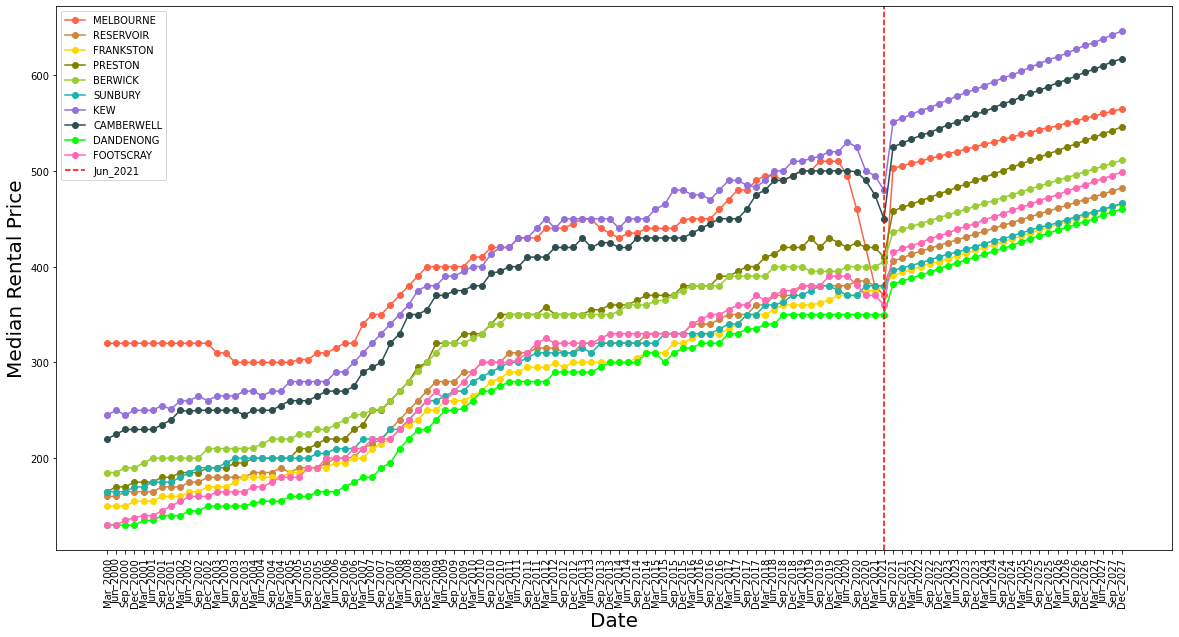

In [353]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (20,10))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Median Rental Price', fontsize=20)

plt.xticks(rotation = 90)
colors=["tomato","peru","gold","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'violet', 'aquamarine','mediumblue','aquamarine']
i = 0
for suburb in suburb_lis:
    if rental[rental['surburb'] == suburb].shape[0] > 0:
        df = rental[rental['surburb'] == suburb].transpose().reset_index()
        df.columns =['Date', suburb]
        df['Date'] = df['Date'].str.slice(start=13)
        df = df.drop([0])
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', marker = 'o', label = suburb)
        i+=1

ax.axvline(x='Jun_2021', color='r', linestyle='--', label = 'Jun_2021')
plt.legend()
fig.figure.savefig('../plots/rental.png')

In [323]:
income

,SA2_Code,2014-15_median_income,2015-16_median_income,2016-17_median_income,2017-18_median_income,2018-19_median_income,2019-20_median_income,2020-21_median_income,2021-22_median_income,2022-23_median_income,2023-24_median_income,2024-25_median_income,2025-26_median_income,2026-27_median_income,2027-28_median_income,SA2_name
0,206041122.0,32697.0,31242.0,28068.0,28806.0,30024.0,27832.8,27054.6,26276.4,25498.2,24720.0,23941.8,23163.6,22385.4,21607.2,Melbourne
1,206041119.0,67966.0,71551.0,70034.0,71759.0,75755.0,76148.8,77727.4,79306.0,80884.6,82463.2,84041.8,85620.4,87199.0,88777.6,East Melbourne
2,206041127.0,0.0,0.0,58023.0,93272.0,82813.0,124491.0,150380.8,176270.6,202160.4,228050.2,253940.0,279829.8,305719.6,331609.4,West Melbourne
3,206041126.0,54176.0,54683.0,50643.0,51696.0,53390.0,51549.9,51094.0,50638.1,50182.2,49726.3,49270.4,48814.5,48358.6,47902.7,Southbank
4,206041125.0,66468.0,65975.0,65330.0,68512.0,70451.0,70498.1,71548.4,72598.7,73649.0,74699.3,75749.6,76799.9,77850.2,78900.5,South Yarra - West
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,212031300.0,43440.0,44122.0,45153.0,46576.0,48067.0,48984.0,50154.8,51325.6,52496.4,53667.2,54838.0,56008.8,57179.6,58350.4,Cranbourne
440,212031301.0,48778.0,49991.0,50947.0,51548.0,52844.0,53728.3,54697.2,55666.1,56635.0,57603.9,58572.8,59541.7,60510.6,61479.5,Cranbourne East
441,212031302.0,46554.0,47344.0,48130.0,49514.0,50912.0,51756.6,52845.2,53933.8,55022.4,56111.0,57199.6,58288.2,59376.8,60465.4,Cranbourne North
442,212031304.0,47241.0,48301.0,48956.0,49496.0,50591.0,51285.5,52075.0,52864.5,53654.0,54443.5,55233.0,56022.5,56812.0,57601.5,Cranbourne West


In [278]:
population['growth_rate_22-25'] = (population['2025_population'] - population['2022_population']) / population['2022_population']
population_top_10_growth = population.sort_values(by=['growth_rate_22-25'], ascending=False).head(20)[['SA2_name','growth_rate_22-25']]
population_top_10_growth.style.format({'growth_rate_22-25': '{:,.2%}'.format})

,SA2_name,growth_rate_22-25
214,Moorabbin Airport,19.71%
261,Essendon Airport,19.68%
364,Clyde North - South,19.64%
363,Clyde North - North,18.99%
448,Tarneit - North,18.92%
428,Cobblebank - Strathtulloh,18.90%
446,Tarneit (West) - Mount Cottrell,18.88%
147,Port Melbourne Industrial,18.72%
85,Alps - East,18.48%
294,Craigieburn - North West,18.36%


In [279]:
income['growth_rate'] = (income['2024-25_median_income'] - income['2021-22_median_income']) / income['2021-22_median_income']
income_top_10_growth = income.sort_values(by=['growth_rate'], ascending=False).head(20)[['SA2_name','growth_rate']]
income_top_10_growth.style.format({'growth_rate': '{:,.2%}'.format})

,SA2_name,growth_rate
434,Wilsons Promontory,44.22%
2,West Melbourne,44.06%
216,Moorabbin Airport,43.27%
414,Alps - East,42.91%
55,Essendon Airport,42.53%
298,Buloke,19.14%
296,Horsham Region,18.28%
28,Rockbank - Mount Cottrell,17.03%
295,Yarriambiack,16.83%
267,West Wimmera,16.66%


['MELBOURNE',
 'RESERVOIR',
 'FRANKSTON',
 'PRESTON',
 'BERWICK',
 'WERRIBEE',
 'SUNBURY',
 'COBURG',
 'KEW',
 'CAMBERWELL',
 'MORNINGTON',
 'CROYDON',
 'DANDENONG',
 'FOOTSCRAY',
 'HOPPERS CROSSING',
 'FERNTREE GULLY',
 'BUNDOORA',
 'EPPING',
 'RINGWOOD',
 'CRAIGIEBURN',
 'PAKENHAM',
 'MOUNT WAVERLEY',
 'ENDEAVOUR HILLS',
 'ST KILDA',
 'BRIGHTON',
 'ROWVILLE',
 'WILLIAMSTOWN',
 'CHELTENHAM',
 'MILDURA',
 'BRUNSWICK',
 'TARNEIT',
 'BENTLEIGH EAST',
 'BORONIA',
 'HAWTHORN',
 'DONCASTER EAST',
 'WODONGA',
 'ESSENDON',
 'GREENSBOROUGH',
 'RICHMOND',
 'NORTHCOTE',
 'WARRNAMBOOL',
 'BALWYN NORTH',
 'BROADMEADOWS',
 'MILL PARK',
 'GLEN IRIS',
 'MULGRAVE',
 'KEYSBOROUGH',
 'GLENROY',
 'SOUTH YARRA',
 'MOUNT MARTHA',
 'SEAFORD',
 'SPRINGVALE',
 'LILYDALE',
 'ROSEBUD',
 'BURWOOD',
 'YARRAVILLE',
 'DONCASTER',
 'HAMPTON PARK',
 'NOBLE PARK',
 'SHEPPARTON',
 'THOMASTOWN',
 'THORNBURY',
 'MARIBYRNONG',
 'MOOROOLBARK',
 'SUNSHINE',
 'TOORAK',
 'MITCHAM',
 'NEWPORT',
 'CARRUM DOWNS',
 'CLAYTON',
 'T

In [354]:
rental['growth_rate_22-23'] = (rental['Rental_total_Sep_2023'] - rental['Rental_total_Sep_2022']) / rental['Rental_total_Sep_2022']
rental['growth_rate_23-24'] = (rental['Rental_total_Sep_2024'] - rental['Rental_total_Sep_2023']) / rental['Rental_total_Sep_2023']
rental['growth_rate_24-25'] = (rental['Rental_total_Sep_2025'] - rental['Rental_total_Sep_2024']) / rental['Rental_total_Sep_2024']
rental['growth_rate_25-26'] = (rental['Rental_total_Sep_2026'] - rental['Rental_total_Sep_2025']) / rental['Rental_total_Sep_2025']
rental['growth_rate_26-27'] = (rental['Rental_total_Sep_2027'] - rental['Rental_total_Sep_2026']) / rental['Rental_total_Sep_2026']
rental['growth_rate_22-25'] = (rental['Rental_total_Sep_2025'] - rental['Rental_total_Sep_2022']) / rental['Rental_total_Sep_2022']
rental_top_10_growth = rental.sort_values(by=['growth_rate_22-25'], ascending=False).head(10)[['surburb','growth_rate_22-25']]
rental_top_10_growth.style.format({'growth_rate_22-25': '{:,.2%}'.format})

,surburb,growth_rate_22-25
35,WEST FOOTSCRAY,9.75%
80,TORQUAY,9.71%
56,DANDENONG,9.64%
59,SPRINGVALE,9.57%
138,SPOTSWOOD,9.51%
137,NEWPORT,9.51%
47,THORNBURY,9.37%
31,FOOTSCRAY,9.32%
55,CRANBOURNE,9.30%
24,CARNEGIE,9.28%


In [280]:
Melbourne = rental[rental['surburb'] == 'MELBOURNE'][['Rental_total_Sep_2000', 'Rental_total_Sep_2001', 'Rental_total_Sep_2002', 'Rental_total_Sep_2003', 'Rental_total_Sep_2004', 'Rental_total_Sep_2005', 'Rental_total_Sep_2006', 'Rental_total_Sep_2007', 'Rental_total_Sep_2008', 'Rental_total_Sep_2009', 'Rental_total_Sep_2010', 'Rental_total_Sep_2011', 'Rental_total_Sep_2012', 'Rental_total_Sep_2013', 'Rental_total_Sep_2014', 'Rental_total_Sep_2015', 'Rental_total_Sep_2016', 'Rental_total_Sep_2017', 'Rental_total_Sep_2018', 'Rental_total_Sep_2019', 'Rental_total_Sep_2020', 'Rental_total_Sep_2021', 'Rental_total_Sep_2022', 'Rental_total_Sep_2023', 'Rental_total_Sep_2024', 'Rental_total_Sep_2025', 'Rental_total_Sep_2026', 'Rental_total_Sep_2027']].transpose().reset_index()
Melbourne.columns = ['Time','MELBOURNE']
Melbourne['Time'] = Melbourne['Time'].str.slice(start=13)

In [281]:
rental[rental['surburb'] == 'MELBOURNE'].transpose()

,91
surburb,MELBOURNE
Rental_total_Mar_2000,320
Rental_total_Jun_2000,320
Rental_total_Sep_2000,320
Rental_total_Dec_2000,320
...,...
growth_rate_23-24,0.01912
growth_rate_24-25,0.018762
growth_rate_25-26,0.016575
growth_rate_26-27,0.018116


In [214]:
Melbourne

,Time,MELBOURNE
0,Sep_2000,320
1,Sep_2001,320
2,Sep_2002,320
3,Sep_2003,300
4,Sep_2004,300
5,Sep_2005,303
6,Sep_2006,320
7,Sep_2007,350
8,Sep_2008,390
9,Sep_2009,400


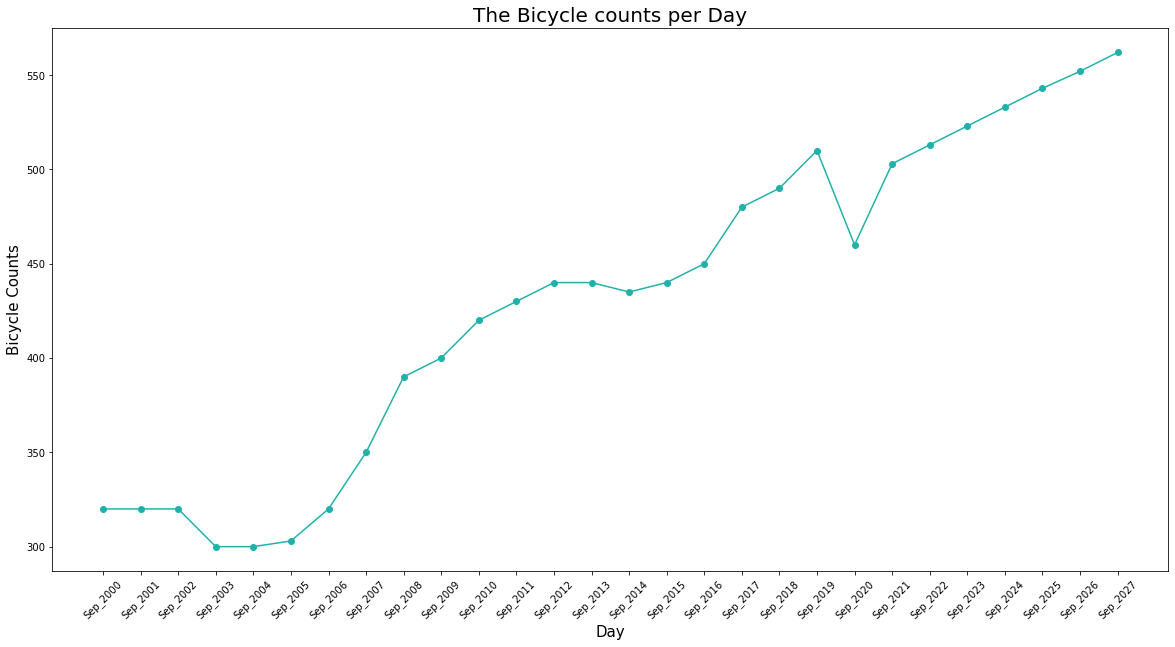

In [215]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(Melbourne['Time'], Melbourne['MELBOURNE'], color = "lightseagreen",
        linestyle = 'solid', marker = 'o', label = "Wind Speed")
plt.xticks(rotation =45)
plt.ylabel('Bicycle Counts', fontsize=15)
plt.xlabel("Day", fontsize=15)
plt.title("The Bicycle counts per Day", size=20)
plt.show()
fig.figure.savefig('../plots/melbounre_rental.png')

In [ ]:
#plot the graph
plt.figure(figsize=(15,10))
plt.plot(sse.keys(),sse.values(),color='magenta',marker='*',linestyle='-',linewidth=3,markersize=10)
plt.legend(["SSE value of the k-means clustering"],loc="best")
plt.title("SSE value of the k-means clustering of the foodscaled versus k value ",size=20)
plt.ylabel('SSE value',size=20)
plt.xlabel('K value',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.xticks(rotation =45)
plt.show()

In [ ]:
# Pearson correlation
fig, ax = plt.subplots(figsize = (12,10))
fig = sns.heatmap(property_df.corr())
fig.figure.savefig('../plots/heatmap.png',bbox_inches = 'tight')

In [57]:
def convert_suburb(df):
    suburb_lis = list(df['suburb'].unique())
    for i in range(1,len(suburb_lis)+1):
        df['suburb'] = df['suburb'].replace(suburb_lis[i-1],i)
    return df

property_df['type'] = property_df['type'].replace('Apartment / Unit / Flat / Penhouse', 1)
property_df['type'] = property_df['type'].replace('Studio', 2)
property_df['type'] = property_df['type'].replace('House', 3)
property_df = convert_suburb(property_df)

property_df = property_df.drop(columns=['postcode'])

In [58]:
print(list(property_df.columns))

['address', 'rent_weekly', 'floor', 'suburb', 'type', 'furnitured', 'pool', 'gym', 'num_bed', 'num_bath', 'num_car_park', 'coordinates', 'SECONDARY SCHOOL', 'PRIMARY AND SECONDARY SCHOOL', 'PRIMARY SCHOOL', 'SHOPPING CENTRE', 'PARK', 'KINDERGARTEN', 'POST OFFICE', 'SPECIAL SCHOOL', 'CHILD CARE', 'BAR', 'SPORTS COMPLEX', 'EDUCATION COMPLEX', 'CEMETERY', 'LIBRARY', 'UNIVERSITY', 'GENERAL HOSPITAL', 'POLICE STATION', 'FURTHER EDUCATION', 'PLAYGROUND', 'PLANTATION', 'WINERY', 'FARM', 'VINEYARD', 'TENNIS COURT', 'BAY', 'PIER', 'SWIMMING POOL', 'ART GALLERY', 'HARBOUR', 'COMMUNITY HEALTH CENTRE', 'MARKET', 'PRISON', 'BOTANIC GARDENS', 'SPECIALISED HOSPITAL', 'BANK', 'AGED CARE', 'SURFING SPOT', 'COAST', 'GOLF COURSE', 'HELIPORT', 'AIRPORT', 'IRON ORE PROCESSOR', 'MILL/TIMBER OPERATIONS', 'BEACH', 'TRAIN STATION', 'TRAM STATION', 'BUS', 'Education', 'Commercial', 'Environment', 'Medication', 'Secrity', 'Industrial', 'Prison', 'Transportation', 'counts', 'livable']


In [59]:
internal = property_df[['address', 'rent_weekly', 'floor', 'suburb', 'type', 'furnitured', 'pool', 'gym', 'num_bed', 'num_bath', 'num_car_park']]
external = property_df[['address', 'rent_weekly','SECONDARY SCHOOL', 'PRIMARY AND SECONDARY SCHOOL', 'PRIMARY SCHOOL', 'SHOPPING CENTRE', 'PARK', 'KINDERGARTEN', 'POST OFFICE', 'SPECIAL SCHOOL', 'CHILD CARE', 'BAR', 'SPORTS COMPLEX', 'EDUCATION COMPLEX', 'CEMETERY', 'LIBRARY', 'UNIVERSITY', 'GENERAL HOSPITAL', 'POLICE STATION', 'FURTHER EDUCATION', 'PLAYGROUND', 'PLANTATION', 'WINERY', 'FARM', 'VINEYARD', 'TENNIS COURT', 'BAY', 'PIER', 'SWIMMING POOL', 'ART GALLERY', 'HARBOUR', 'COMMUNITY HEALTH CENTRE', 'MARKET', 'PRISON', 'BOTANIC GARDENS', 'SPECIALISED HOSPITAL', 'BANK', 'AGED CARE', 'SURFING SPOT', 'COAST', 'GOLF COURSE', 'HELIPORT', 'AIRPORT', 'IRON ORE PROCESSOR', 'MILL/TIMBER OPERATIONS', 'BEACH', 'TRAIN STATION', 'TRAM STATION', 'BUS']]
dimension = property_df[['address', 'rent_weekly','Education', 'Commercial', 'Environment', 'Medication', 'Secrity', 'Industrial', 'Prison', 'Transportation']]

In [60]:
internal.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

,rent_weekly
rent_weekly,1.000000
type,0.120412
gym,0.109401
floor,0.101841
suburb,0.096452
num_bed,0.093900
pool,0.091041
num_car_park,0.082851
furnitured,0.036077
num_bath,0.025824


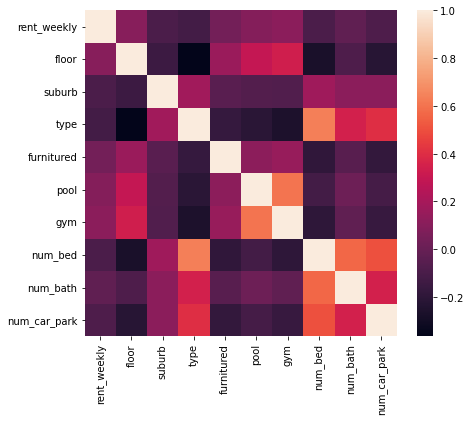

In [61]:
# Pearson correlation
fig, ax = plt.subplots(figsize = (7,6))
fig = sns.heatmap(internal.corr())
fig.figure.savefig('../plots/heatmap_internal.png',bbox_inches = 'tight')

In [62]:
internal[internal['type'] == 1].corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

,rent_weekly
rent_weekly,1.000000
gym,0.126772
pool,0.102632
floor,0.101654
suburb,0.084698
num_car_park,0.052256
num_bath,0.049523
num_bed,0.041645
furnitured,0.037907
type,NaN


In [63]:
internal[internal['type'] == 3].corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

,rent_weekly
rent_weekly,1.000000
suburb,0.072057
num_car_park,0.032713
pool,0.023810
num_bed,0.015205
floor,0.008797
gym,0.008449
furnitured,0.003345
num_bath,0.002202
type,NaN


In [64]:
external.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(15)

,rent_weekly
rent_weekly,1.000000
TRAM STATION,0.174567
POST OFFICE,0.147616
SPORTS COMPLEX,0.133844
MARKET,0.123225
POLICE STATION,0.117222
TRAIN STATION,0.113993
BOTANIC GARDENS,0.096230
SECONDARY SCHOOL,0.091323
GENERAL HOSPITAL,0.086397


In [65]:
external.columns

Index(['address', 'rent_weekly', 'SECONDARY SCHOOL',
       'PRIMARY AND SECONDARY SCHOOL', 'PRIMARY SCHOOL', 'SHOPPING CENTRE',
       'PARK', 'KINDERGARTEN', 'POST OFFICE', 'SPECIAL SCHOOL', 'CHILD CARE',
       'BAR', 'SPORTS COMPLEX', 'EDUCATION COMPLEX', 'CEMETERY', 'LIBRARY',
       'UNIVERSITY', 'GENERAL HOSPITAL', 'POLICE STATION', 'FURTHER EDUCATION',
       'PLAYGROUND', 'PLANTATION', 'WINERY', 'FARM', 'VINEYARD',
       'TENNIS COURT', 'BAY', 'PIER', 'SWIMMING POOL', 'ART GALLERY',
       'HARBOUR', 'COMMUNITY HEALTH CENTRE', 'MARKET', 'PRISON',
       'BOTANIC GARDENS', 'SPECIALISED HOSPITAL', 'BANK', 'AGED CARE',
       'SURFING SPOT', 'COAST', 'GOLF COURSE', 'HELIPORT', 'AIRPORT',
       'IRON ORE PROCESSOR', 'MILL/TIMBER OPERATIONS', 'BEACH',
       'TRAIN STATION', 'TRAM STATION', 'BUS'],
      dtype='object')

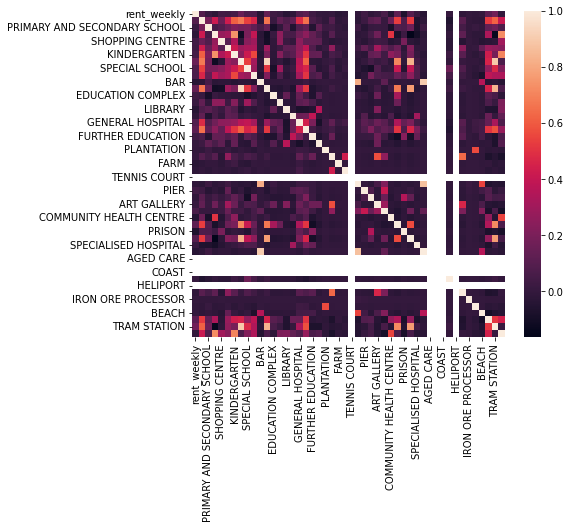

In [66]:
# Pearson correlation
fig, ax = plt.subplots(figsize = (7,6))
fig = sns.heatmap(external.corr())
fig.figure.savefig('../plots/heatmap_internal.png',bbox_inches = 'tight')

In [67]:
dimension.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(15)

,rent_weekly
rent_weekly,1.000000
Commercial,0.156781
Secrity,0.117222
Medication,0.083742
Transportation,0.068083
Prison,0.066797
Environment,0.050913
Education,0.049204
Industrial,0.032781


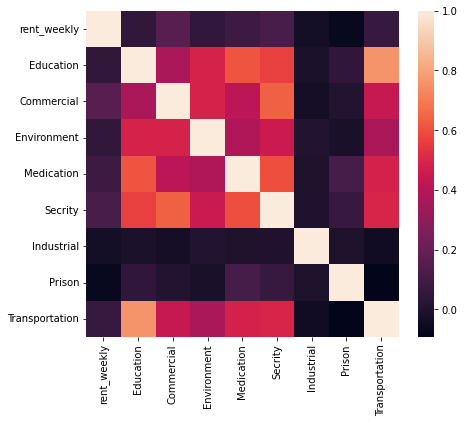

In [68]:
# Pearson correlation
fig, ax = plt.subplots(figsize = (7,6))
fig = sns.heatmap(dimension.corr())
fig.figure.savefig('../plots/heatmap_internal.png',bbox_inches = 'tight')

,surburb,growth_rate_22-25
35,WEST FOOTSCRAY,0.097506
80,TORQUAY,0.097122
56,DANDENONG,0.096447
59,SPRINGVALE,0.095672
138,SPOTSWOOD,0.095064
137,NEWPORT,0.095064
47,THORNBURY,0.093682
31,FOOTSCRAY,0.093240
55,CRANBOURNE,0.092971
24,CARNEGIE,0.092827


In [103]:
population

,SA2_Code,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,...,2019_population,2020_population,2021_population,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population,SA2_name
0,201011001.0,5756.0,6092.0,6293.0,6480.0,6648.0,6761.0,7034.0,7272.0,7614.0,...,14408.0,15472.0,16823.0,15311.595238,15832.731602,16353.867965,16875.004329,17396.140693,17917.277056,Alfredton
1,201011002.0,11497.0,11708.0,12015.0,12189.0,12269.0,12356.0,12408.0,12480.0,12476.0,...,12311.0,12183.0,12076.0,12394.790476,12409.338528,12423.886580,12438.434632,12452.982684,12467.530736,Ballarat
2,201011005.0,5320.0,5399.0,5557.0,5620.0,5857.0,6037.0,6131.0,6252.0,6431.0,...,7452.0,7369.0,7232.0,7843.657143,7958.366234,8073.075325,8187.784416,8302.493506,8417.202597,Buninyong
3,201011006.0,4154.0,4225.0,4371.0,4465.0,4704.0,5041.0,5206.0,5349.0,5557.0,...,8876.0,9736.0,10640.0,9408.423810,9689.869264,9971.314719,10252.760173,10534.205628,10815.651082,Delacombe
4,201011007.0,3317.0,3378.0,3411.0,3473.0,3508.0,3542.0,3594.0,3658.0,3714.0,...,4109.0,4148.0,4213.0,4258.819048,4302.317749,4345.816450,4389.315152,4432.813853,4476.312554,Smythes Creek
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,217031476.0,3452.0,3479.0,3511.0,3511.0,3492.0,3459.0,3489.0,3501.0,3490.0,...,3797.0,3905.0,3978.0,3769.214286,3787.844156,3806.474026,3825.103896,3843.733766,3862.363636,Otway
518,217041477.0,6718.0,6704.0,6676.0,6643.0,6638.0,6652.0,6606.0,6631.0,6703.0,...,6790.0,6873.0,6989.0,6833.276190,6842.933333,6852.590476,6862.247619,6871.904762,6881.561905,Moyne - East
519,217041478.0,8317.0,8387.0,8450.0,8487.0,8517.0,8601.0,8694.0,8792.0,8878.0,...,9833.0,9842.0,9963.0,10065.800000,10153.496104,10241.192208,10328.888312,10416.584416,10504.280519,Moyne - West
520,217041479.0,17053.0,17449.0,17726.0,17937.0,18172.0,18528.0,18877.0,19107.0,19369.0,...,22157.0,22379.0,22462.0,23019.880952,23299.640693,23579.400433,23859.160173,24138.919913,24418.679654,Warrnambool - North


In [ ]:
# read rental data
path = os.getcwd().replace("notebooks","") + "data/curated/"
df = pd.read_csv(path+'rental_median.csv', low_memory = True)
df = df.drop_duplicates()
df = df[['Suburb','Rental_total_Mar_2000_1b_flat', 'Rental_total_Jun_2000_1b_flat', 'Rental_total_Sep_2000_1b_flat', 'Rental_total_Dec_2000_1b_flat', 'Rental_total_Mar_2001_1b_flat', 'Rental_total_Jun_2001_1b_flat', 'Rental_total_Sep_2001_1b_flat', 'Rental_total_Dec_2001_1b_flat', 'Rental_total_Mar_2002_1b_flat', 'Rental_total_Jun_2002_1b_flat', 'Rental_total_Sep_2002_1b_flat', 'Rental_total_Dec_2002_1b_flat', 'Rental_total_Mar_2003_1b_flat', 'Rental_total_Jun_2003_1b_flat', 'Rental_total_Sep_2003_1b_flat', 'Rental_total_Dec_2003_1b_flat', 'Rental_total_Mar_2004_1b_flat', 'Rental_total_Jun_2004_1b_flat', 'Rental_total_Sep_2004_1b_flat', 'Rental_total_Dec_2004_1b_flat', 'Rental_total_Mar_2005_1b_flat', 'Rental_total_Jun_2005_1b_flat', 'Rental_total_Sep_2005_1b_flat', 'Rental_total_Dec_2005_1b_flat', 'Rental_total_Mar_2006_1b_flat', 'Rental_total_Jun_2006_1b_flat', 'Rental_total_Sep_2006_1b_flat', 'Rental_total_Dec_2006_1b_flat', 'Rental_total_Mar_2007_1b_flat', 'Rental_total_Jun_2007_1b_flat', 'Rental_total_Sep_2007_1b_flat', 'Rental_total_Dec_2007_1b_flat', 'Rental_total_Mar_2008_1b_flat', 'Rental_total_Jun_2008_1b_flat', 'Rental_total_Sep_2008_1b_flat', 'Rental_total_Dec_2008_1b_flat', 'Rental_total_Mar_2009_1b_flat', 'Rental_total_Jun_2009_1b_flat', 'Rental_total_Sep_2009_1b_flat', 'Rental_total_Dec_2009_1b_flat', 'Rental_total_Mar_2010_1b_flat', 'Rental_total_Jun_2010_1b_flat', 'Rental_total_Sep_2010_1b_flat', 'Rental_total_Dec_2010_1b_flat', 'Rental_total_Mar_2011_1b_flat', 'Rental_total_Jun_2011_1b_flat', 'Rental_total_Sep_2011_1b_flat', 'Rental_total_Dec_2011_1b_flat', 'Rental_total_Mar_2012_1b_flat', 'Rental_total_Jun_2012_1b_flat', 'Rental_total_Sep_2012_1b_flat', 'Rental_total_Dec_2012_1b_flat', 'Rental_total_Mar_2013_1b_flat', 'Rental_total_Jun_2013_1b_flat', 'Rental_total_Sep_2013_1b_flat', 'Rental_total_Dec_2013_1b_flat', 'Rental_total_Mar_2014_1b_flat', 'Rental_total_Jun_2014_1b_flat', 'Rental_total_Sep_2014_1b_flat', 'Rental_total_Dec_2014_1b_flat', 'Rental_total_Mar_2015_1b_flat', 'Rental_total_Jun_2015_1b_flat', 'Rental_total_Sep_2015_1b_flat', 'Rental_total_Dec_2015_1b_flat', 'Rental_total_Mar_2016_1b_flat', 'Rental_total_Jun_2016_1b_flat', 'Rental_total_Sep_2016_1b_flat', 'Rental_total_Dec_2016_1b_flat', 'Rental_total_Mar_2017_1b_flat', 'Rental_total_Jun_2017_1b_flat', 'Rental_total_Sep_2017_1b_flat', 'Rental_total_Dec_2017_1b_flat', 'Rental_total_Mar_2018_1b_flat', 'Rental_total_Jun_2018_1b_flat', 'Rental_total_Sep_2018_1b_flat', 'Rental_total_Dec_2018_1b_flat', 'Rental_total_Mar_2019_1b_flat', 'Rental_total_Jun_2019_1b_flat', 'Rental_total_Sep_2019_1b_flat', 'Rental_total_Dec_2019_1b_flat', 'Rental_total_Mar_2020_1b_flat', 'Rental_total_Jun_2020_1b_flat', 'Rental_total_Sep_2020_1b_flat', 'Rental_total_Dec_2020_1b_flat', 'Rental_total_Mar_2021_1b_flat', 'Rental_total_Jun_2021_1b_flat', 'Rental_total_Mar_2000_2b_flat', 'Rental_total_Jun_2000_2b_flat', 'Rental_total_Sep_2000_2b_flat', 'Rental_total_Dec_2000_2b_flat', 'Rental_total_Mar_2001_2b_flat', 'Rental_total_Jun_2001_2b_flat', 'Rental_total_Sep_2001_2b_flat', 'Rental_total_Dec_2001_2b_flat', 'Rental_total_Mar_2002_2b_flat', 'Rental_total_Jun_2002_2b_flat', 'Rental_total_Sep_2002_2b_flat', 'Rental_total_Dec_2002_2b_flat', 'Rental_total_Mar_2003_2b_flat', 'Rental_total_Jun_2003_2b_flat', 'Rental_total_Sep_2003_2b_flat', 'Rental_total_Dec_2003_2b_flat', 'Rental_total_Mar_2004_2b_flat', 'Rental_total_Jun_2004_2b_flat', 'Rental_total_Sep_2004_2b_flat', 'Rental_total_Dec_2004_2b_flat', 'Rental_total_Mar_2005_2b_flat', 'Rental_total_Jun_2005_2b_flat', 'Rental_total_Sep_2005_2b_flat', 'Rental_total_Dec_2005_2b_flat', 'Rental_total_Mar_2006_2b_flat', 'Rental_total_Jun_2006_2b_flat', 'Rental_total_Sep_2006_2b_flat', 'Rental_total_Dec_2006_2b_flat', 'Rental_total_Mar_2007_2b_flat', 'Rental_total_Jun_2007_2b_flat', 'Rental_total_Sep_2007_2b_flat', 'Rental_total_Dec_2007_2b_flat', 'Rental_total_Mar_2008_2b_flat', 'Rental_total_Jun_2008_2b_flat', 'Rental_total_Sep_2008_2b_flat', 'Rental_total_Dec_2008_2b_flat', 'Rental_total_Mar_2009_2b_flat', 'Rental_total_Jun_2009_2b_flat', 'Rental_total_Sep_2009_2b_flat', 'Rental_total_Dec_2009_2b_flat', 'Rental_total_Mar_2010_2b_flat', 'Rental_total_Jun_2010_2b_flat', 'Rental_total_Sep_2010_2b_flat', 'Rental_total_Dec_2010_2b_flat', 'Rental_total_Mar_2011_2b_flat', 'Rental_total_Jun_2011_2b_flat', 'Rental_total_Sep_2011_2b_flat', 'Rental_total_Dec_2011_2b_flat', 'Rental_total_Mar_2012_2b_flat', 'Rental_total_Jun_2012_2b_flat', 'Rental_total_Sep_2012_2b_flat', 'Rental_total_Dec_2012_2b_flat', 'Rental_total_Mar_2013_2b_flat', 'Rental_total_Jun_2013_2b_flat', 'Rental_total_Sep_2013_2b_flat', 'Rental_total_Dec_2013_2b_flat', 'Rental_total_Mar_2014_2b_flat', 'Rental_total_Jun_2014_2b_flat', 'Rental_total_Sep_2014_2b_flat', 'Rental_total_Dec_2014_2b_flat', 'Rental_total_Mar_2015_2b_flat', 'Rental_total_Jun_2015_2b_flat', 'Rental_total_Sep_2015_2b_flat', 'Rental_total_Dec_2015_2b_flat', 'Rental_total_Mar_2016_2b_flat', 'Rental_total_Jun_2016_2b_flat', 'Rental_total_Sep_2016_2b_flat', 'Rental_total_Dec_2016_2b_flat', 'Rental_total_Mar_2017_2b_flat', 'Rental_total_Jun_2017_2b_flat', 'Rental_total_Sep_2017_2b_flat', 'Rental_total_Dec_2017_2b_flat', 'Rental_total_Mar_2018_2b_flat', 'Rental_total_Jun_2018_2b_flat', 'Rental_total_Sep_2018_2b_flat', 'Rental_total_Dec_2018_2b_flat', 'Rental_total_Mar_2019_2b_flat', 'Rental_total_Jun_2019_2b_flat', 'Rental_total_Sep_2019_2b_flat', 'Rental_total_Dec_2019_2b_flat', 'Rental_total_Mar_2020_2b_flat', 'Rental_total_Jun_2020_2b_flat', 'Rental_total_Sep_2020_2b_flat', 'Rental_total_Dec_2020_2b_flat', 'Rental_total_Mar_2021_2b_flat', 'Rental_total_Jun_2021_2b_flat', 'Rental_total_Mar_2000_3b_flat', 'Rental_total_Jun_2000_3b_flat', 'Rental_total_Sep_2000_3b_flat', 'Rental_total_Dec_2000_3b_flat', 'Rental_total_Mar_2001_3b_flat', 'Rental_total_Jun_2001_3b_flat', 'Rental_total_Sep_2001_3b_flat', 'Rental_total_Dec_2001_3b_flat', 'Rental_total_Mar_2002_3b_flat', 'Rental_total_Jun_2002_3b_flat', 'Rental_total_Sep_2002_3b_flat', 'Rental_total_Dec_2002_3b_flat', 'Rental_total_Mar_2003_3b_flat', 'Rental_total_Jun_2003_3b_flat', 'Rental_total_Sep_2003_3b_flat', 'Rental_total_Dec_2003_3b_flat', 'Rental_total_Mar_2004_3b_flat', 'Rental_total_Jun_2004_3b_flat', 'Rental_total_Sep_2004_3b_flat', 'Rental_total_Dec_2004_3b_flat', 'Rental_total_Mar_2005_3b_flat', 'Rental_total_Jun_2005_3b_flat', 'Rental_total_Sep_2005_3b_flat', 'Rental_total_Dec_2005_3b_flat', 'Rental_total_Mar_2006_3b_flat', 'Rental_total_Jun_2006_3b_flat', 'Rental_total_Sep_2006_3b_flat', 'Rental_total_Dec_2006_3b_flat', 'Rental_total_Mar_2007_3b_flat', 'Rental_total_Jun_2007_3b_flat', 'Rental_total_Sep_2007_3b_flat', 'Rental_total_Dec_2007_3b_flat', 'Rental_total_Mar_2008_3b_flat', 'Rental_total_Jun_2008_3b_flat', 'Rental_total_Sep_2008_3b_flat', 'Rental_total_Dec_2008_3b_flat', 'Rental_total_Mar_2009_3b_flat', 'Rental_total_Jun_2009_3b_flat', 'Rental_total_Sep_2009_3b_flat', 'Rental_total_Dec_2009_3b_flat', 'Rental_total_Mar_2010_3b_flat', 'Rental_total_Jun_2010_3b_flat', 'Rental_total_Sep_2010_3b_flat', 'Rental_total_Dec_2010_3b_flat', 'Rental_total_Mar_2011_3b_flat', 'Rental_total_Jun_2011_3b_flat', 'Rental_total_Sep_2011_3b_flat', 'Rental_total_Dec_2011_3b_flat', 'Rental_total_Mar_2012_3b_flat', 'Rental_total_Jun_2012_3b_flat', 'Rental_total_Sep_2012_3b_flat', 'Rental_total_Dec_2012_3b_flat', 'Rental_total_Mar_2013_3b_flat', 'Rental_total_Jun_2013_3b_flat', 'Rental_total_Sep_2013_3b_flat', 'Rental_total_Dec_2013_3b_flat', 'Rental_total_Mar_2014_3b_flat', 'Rental_total_Jun_2014_3b_flat', 'Rental_total_Sep_2014_3b_flat', 'Rental_total_Dec_2014_3b_flat', 'Rental_total_Mar_2015_3b_flat', 'Rental_total_Jun_2015_3b_flat', 'Rental_total_Sep_2015_3b_flat', 'Rental_total_Dec_2015_3b_flat', 'Rental_total_Mar_2016_3b_flat', 'Rental_total_Jun_2016_3b_flat', 'Rental_total_Sep_2016_3b_flat', 'Rental_total_Dec_2016_3b_flat', 'Rental_total_Mar_2017_3b_flat', 'Rental_total_Jun_2017_3b_flat', 'Rental_total_Sep_2017_3b_flat', 'Rental_total_Dec_2017_3b_flat', 'Rental_total_Mar_2018_3b_flat', 'Rental_total_Jun_2018_3b_flat', 'Rental_total_Sep_2018_3b_flat', 'Rental_total_Dec_2018_3b_flat', 'Rental_total_Mar_2019_3b_flat', 'Rental_total_Jun_2019_3b_flat', 'Rental_total_Sep_2019_3b_flat', 'Rental_total_Dec_2019_3b_flat', 'Rental_total_Mar_2020_3b_flat', 'Rental_total_Jun_2020_3b_flat', 'Rental_total_Sep_2020_3b_flat', 'Rental_total_Dec_2020_3b_flat', 'Rental_total_Mar_2021_3b_flat', 'Rental_total_Jun_2021_3b_flat', 'Rental_total_Mar_2000_2b_house', 'Rental_total_Jun_2000_2b_house', 'Rental_total_Sep_2000_2b_house', 'Rental_total_Dec_2000_2b_house', 'Rental_total_Mar_2001_2b_house', 'Rental_total_Jun_2001_2b_house', 'Rental_total_Sep_2001_2b_house', 'Rental_total_Dec_2001_2b_house', 'Rental_total_Mar_2002_2b_house', 'Rental_total_Jun_2002_2b_house', 'Rental_total_Sep_2002_2b_house', 'Rental_total_Dec_2002_2b_house', 'Rental_total_Mar_2003_2b_house', 'Rental_total_Jun_2003_2b_house', 'Rental_total_Sep_2003_2b_house', 'Rental_total_Dec_2003_2b_house', 'Rental_total_Mar_2004_2b_house', 'Rental_total_Jun_2004_2b_house', 'Rental_total_Sep_2004_2b_house', 'Rental_total_Dec_2004_2b_house', 'Rental_total_Mar_2005_2b_house', 'Rental_total_Jun_2005_2b_house', 'Rental_total_Sep_2005_2b_house', 'Rental_total_Dec_2005_2b_house', 'Rental_total_Mar_2006_2b_house', 'Rental_total_Jun_2006_2b_house', 'Rental_total_Sep_2006_2b_house', 'Rental_total_Dec_2006_2b_house', 'Rental_total_Mar_2007_2b_house', 'Rental_total_Jun_2007_2b_house', 'Rental_total_Sep_2007_2b_house', 'Rental_total_Dec_2007_2b_house', 'Rental_total_Mar_2008_2b_house', 'Rental_total_Jun_2008_2b_house', 'Rental_total_Sep_2008_2b_house', 'Rental_total_Dec_2008_2b_house', 'Rental_total_Mar_2009_2b_house', 'Rental_total_Jun_2009_2b_house', 'Rental_total_Sep_2009_2b_house', 'Rental_total_Dec_2009_2b_house', 'Rental_total_Mar_2010_2b_house', 'Rental_total_Jun_2010_2b_house', 'Rental_total_Sep_2010_2b_house', 'Rental_total_Dec_2010_2b_house', 'Rental_total_Mar_2011_2b_house', 'Rental_total_Jun_2011_2b_house', 'Rental_total_Sep_2011_2b_house', 'Rental_total_Dec_2011_2b_house', 'Rental_total_Mar_2012_2b_house', 'Rental_total_Jun_2012_2b_house', 'Rental_total_Sep_2012_2b_house', 'Rental_total_Dec_2012_2b_house', 'Rental_total_Mar_2013_2b_house', 'Rental_total_Jun_2013_2b_house', 'Rental_total_Sep_2013_2b_house', 'Rental_total_Dec_2013_2b_house', 'Rental_total_Mar_2014_2b_house', 'Rental_total_Jun_2014_2b_house', 'Rental_total_Sep_2014_2b_house', 'Rental_total_Dec_2014_2b_house', 'Rental_total_Mar_2015_2b_house', 'Rental_total_Jun_2015_2b_house', 'Rental_total_Sep_2015_2b_house', 'Rental_total_Dec_2015_2b_house', 'Rental_total_Mar_2016_2b_house', 'Rental_total_Jun_2016_2b_house', 'Rental_total_Sep_2016_2b_house', 'Rental_total_Dec_2016_2b_house', 'Rental_total_Mar_2017_2b_house', 'Rental_total_Jun_2017_2b_house', 'Rental_total_Sep_2017_2b_house', 'Rental_total_Dec_2017_2b_house', 'Rental_total_Mar_2018_2b_house', 'Rental_total_Jun_2018_2b_house', 'Rental_total_Sep_2018_2b_house', 'Rental_total_Dec_2018_2b_house', 'Rental_total_Mar_2019_2b_house', 'Rental_total_Jun_2019_2b_house', 'Rental_total_Sep_2019_2b_house', 'Rental_total_Dec_2019_2b_house', 'Rental_total_Mar_2020_2b_house', 'Rental_total_Jun_2020_2b_house', 'Rental_total_Sep_2020_2b_house', 'Rental_total_Dec_2020_2b_house', 'Rental_total_Mar_2021_2b_house', 'Rental_total_Jun_2021_2b_house', 'Rental_total_Mar_2000_3b_house', 'Rental_total_Jun_2000_3b_house', 'Rental_total_Sep_2000_3b_house', 'Rental_total_Dec_2000_3b_house', 'Rental_total_Mar_2001_3b_house', 'Rental_total_Jun_2001_3b_house', 'Rental_total_Sep_2001_3b_house', 'Rental_total_Dec_2001_3b_house', 'Rental_total_Mar_2002_3b_house', 'Rental_total_Jun_2002_3b_house', 'Rental_total_Sep_2002_3b_house', 'Rental_total_Dec_2002_3b_house', 'Rental_total_Mar_2003_3b_house', 'Rental_total_Jun_2003_3b_house', 'Rental_total_Sep_2003_3b_house', 'Rental_total_Dec_2003_3b_house', 'Rental_total_Mar_2004_3b_house', 'Rental_total_Jun_2004_3b_house', 'Rental_total_Sep_2004_3b_house', 'Rental_total_Dec_2004_3b_house', 'Rental_total_Mar_2005_3b_house', 'Rental_total_Jun_2005_3b_house', 'Rental_total_Sep_2005_3b_house', 'Rental_total_Dec_2005_3b_house', 'Rental_total_Mar_2006_3b_house', 'Rental_total_Jun_2006_3b_house', 'Rental_total_Sep_2006_3b_house', 'Rental_total_Dec_2006_3b_house', 'Rental_total_Mar_2007_3b_house', 'Rental_total_Jun_2007_3b_house', 'Rental_total_Sep_2007_3b_house', 'Rental_total_Dec_2007_3b_house', 'Rental_total_Mar_2008_3b_house', 'Rental_total_Jun_2008_3b_house', 'Rental_total_Sep_2008_3b_house', 'Rental_total_Dec_2008_3b_house', 'Rental_total_Mar_2009_3b_house', 'Rental_total_Jun_2009_3b_house', 'Rental_total_Sep_2009_3b_house', 'Rental_total_Dec_2009_3b_house', 'Rental_total_Mar_2010_3b_house', 'Rental_total_Jun_2010_3b_house', 'Rental_total_Sep_2010_3b_house', 'Rental_total_Dec_2010_3b_house', 'Rental_total_Mar_2011_3b_house', 'Rental_total_Jun_2011_3b_house', 'Rental_total_Sep_2011_3b_house', 'Rental_total_Dec_2011_3b_house', 'Rental_total_Mar_2012_3b_house', 'Rental_total_Jun_2012_3b_house', 'Rental_total_Sep_2012_3b_house', 'Rental_total_Dec_2012_3b_house', 'Rental_total_Mar_2013_3b_house', 'Rental_total_Jun_2013_3b_house', 'Rental_total_Sep_2013_3b_house', 'Rental_total_Dec_2013_3b_house', 'Rental_total_Mar_2014_3b_house', 'Rental_total_Jun_2014_3b_house', 'Rental_total_Sep_2014_3b_house', 'Rental_total_Dec_2014_3b_house', 'Rental_total_Mar_2015_3b_house', 'Rental_total_Jun_2015_3b_house', 'Rental_total_Sep_2015_3b_house', 'Rental_total_Dec_2015_3b_house', 'Rental_total_Mar_2016_3b_house', 'Rental_total_Jun_2016_3b_house', 'Rental_total_Sep_2016_3b_house', 'Rental_total_Dec_2016_3b_house', 'Rental_total_Mar_2017_3b_house', 'Rental_total_Jun_2017_3b_house', 'Rental_total_Sep_2017_3b_house', 'Rental_total_Dec_2017_3b_house', 'Rental_total_Mar_2018_3b_house', 'Rental_total_Jun_2018_3b_house', 'Rental_total_Sep_2018_3b_house', 'Rental_total_Dec_2018_3b_house', 'Rental_total_Mar_2019_3b_house', 'Rental_total_Jun_2019_3b_house', 'Rental_total_Sep_2019_3b_house', 'Rental_total_Dec_2019_3b_house', 'Rental_total_Mar_2020_3b_house', 'Rental_total_Jun_2020_3b_house', 'Rental_total_Sep_2020_3b_house', 'Rental_total_Dec_2020_3b_house', 'Rental_total_Mar_2021_3b_house', 'Rental_total_Jun_2021_3b_house', 'Rental_total_Mar_2000_4b_house', 'Rental_total_Jun_2000_4b_house', 'Rental_total_Sep_2000_4b_house', 'Rental_total_Dec_2000_4b_house', 'Rental_total_Mar_2001_4b_house', 'Rental_total_Jun_2001_4b_house', 'Rental_total_Sep_2001_4b_house', 'Rental_total_Dec_2001_4b_house', 'Rental_total_Mar_2002_4b_house', 'Rental_total_Jun_2002_4b_house', 'Rental_total_Sep_2002_4b_house', 'Rental_total_Dec_2002_4b_house', 'Rental_total_Mar_2003_4b_house', 'Rental_total_Jun_2003_4b_house', 'Rental_total_Sep_2003_4b_house', 'Rental_total_Dec_2003_4b_house', 'Rental_total_Mar_2004_4b_house', 'Rental_total_Jun_2004_4b_house', 'Rental_total_Sep_2004_4b_house', 'Rental_total_Dec_2004_4b_house', 'Rental_total_Mar_2005_4b_house', 'Rental_total_Jun_2005_4b_house', 'Rental_total_Sep_2005_4b_house', 'Rental_total_Dec_2005_4b_house', 'Rental_total_Mar_2006_4b_house', 'Rental_total_Jun_2006_4b_house', 'Rental_total_Sep_2006_4b_house', 'Rental_total_Dec_2006_4b_house', 'Rental_total_Mar_2007_4b_house', 'Rental_total_Jun_2007_4b_house', 'Rental_total_Sep_2007_4b_house', 'Rental_total_Dec_2007_4b_house', 'Rental_total_Mar_2008_4b_house', 'Rental_total_Jun_2008_4b_house', 'Rental_total_Sep_2008_4b_house', 'Rental_total_Dec_2008_4b_house', 'Rental_total_Mar_2009_4b_house', 'Rental_total_Jun_2009_4b_house', 'Rental_total_Sep_2009_4b_house', 'Rental_total_Dec_2009_4b_house', 'Rental_total_Mar_2010_4b_house', 'Rental_total_Jun_2010_4b_house', 'Rental_total_Sep_2010_4b_house', 'Rental_total_Dec_2010_4b_house', 'Rental_total_Mar_2011_4b_house', 'Rental_total_Jun_2011_4b_house', 'Rental_total_Sep_2011_4b_house', 'Rental_total_Dec_2011_4b_house', 'Rental_total_Mar_2012_4b_house', 'Rental_total_Jun_2012_4b_house', 'Rental_total_Sep_2012_4b_house', 'Rental_total_Dec_2012_4b_house', 'Rental_total_Mar_2013_4b_house', 'Rental_total_Jun_2013_4b_house', 'Rental_total_Sep_2013_4b_house', 'Rental_total_Dec_2013_4b_house', 'Rental_total_Mar_2014_4b_house', 'Rental_total_Jun_2014_4b_house', 'Rental_total_Sep_2014_4b_house', 'Rental_total_Dec_2014_4b_house', 'Rental_total_Mar_2015_4b_house', 'Rental_total_Jun_2015_4b_house', 'Rental_total_Sep_2015_4b_house', 'Rental_total_Dec_2015_4b_house', 'Rental_total_Mar_2016_4b_house', 'Rental_total_Jun_2016_4b_house', 'Rental_total_Sep_2016_4b_house', 'Rental_total_Dec_2016_4b_house', 'Rental_total_Mar_2017_4b_house', 'Rental_total_Jun_2017_4b_house', 'Rental_total_Sep_2017_4b_house', 'Rental_total_Dec_2017_4b_house', 'Rental_total_Mar_2018_4b_house', 'Rental_total_Jun_2018_4b_house', 'Rental_total_Sep_2018_4b_house', 'Rental_total_Dec_2018_4b_house', 'Rental_total_Mar_2019_4b_house', 'Rental_total_Jun_2019_4b_house', 'Rental_total_Sep_2019_4b_house', 'Rental_total_Dec_2019_4b_house', 'Rental_total_Mar_2020_4b_house', 'Rental_total_Jun_2020_4b_house', 'Rental_total_Sep_2020_4b_house', 'Rental_total_Dec_2020_4b_house', 'Rental_total_Mar_2021_4b_house', 'Rental_total_Jun_2021_4b_house', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df = df[['Suburb', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df

In [ ]:
df=df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df["date"] = df.index
df

In [ ]:
def get_date(idx):
    return idx[-8:]
df["date"] = df["date"].apply(get_date)
df

In [ ]:
df.columns[:143]

In [ ]:
for suburb in [x for x in df.columns][:143]:
    df[suburb] = df[suburb].replace("-",np.nan)
    df[suburb] = df[suburb].astype(float)
df.dtypes
df = df.fillna(0)
df

In [ ]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (50,40))
plt.xlabel('Date', fontsize=50)
plt.xticks(rotation = 45)

for suburb in df.columns:
    ax.plot(df['date'], df[suburb], color = "black",linestyle = 'solid', marker = 'o', label = suburb)

plt.legend()
fig.figure.savefig('../plots/rental.png')

In [ ]:
print([x for x in df.columns])

In [ ]:
df["Docklands"]

In [ ]:
lis = []
for i in df.columns:
    if "flat" not in i and "house" not in i:
        lis.append(i)
print(lis)

### Rent according to suburb

suburb_rent = Other_df.groupby('suburb', as_index=False).agg({'rent_weekly':'mean'})
sorted_df = suburb_rent.sort_values(by=['rent_weekly'], ascending=False, ignore_index=True)
sorted_df

In [ ]:
plt.figure(figsize=(20, 100))
plt.barh(sorted_df['suburb'], sorted_df['rent_weekly'], align='edge')
y_num=np.arange(len(suburb_rent['suburb']))
plt.ylim(min(y_num)-1,max(y_num)+1)
plt.show()